In [79]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

In [80]:
# Tensorflow does not support numpy array operations for backprop
# def easy_PTM_depol_channel(depol_mat):
#     PTM_depol = (1 - np.abs(depol_mat)) * np.eye(4)
#     # Create a new tensor with the modified value at index [0, 0]
#     PTM_depol = np.array(PTM_depol)
#     PTM_depol[0, 0] = 1
#     PTM_depol = tf.convert_to_tensor(PTM_depol, dtype=tf.complex64)
#     return PTM_depol

def easy_PTM_depol_channel(depol_mat):
    identity = tf.eye(4, dtype=tf.float32)
    PTM_depol = (1 - tf.math.abs(depol_mat)) * identity
    
    # Update the value at index [0,0] to 1
    # We use Tensorflow operations to ensure gradient computation
    PTM_depol = tf.tensor_scatter_nd_update(PTM_depol, [[0,0]], [1])
    PTM_depol = tf.cast(PTM_depol, dtype=tf.complex64)
    return PTM_depol



def pauli_matrices():
    """Return the Pauli matrices including identity."""
    I = tf.eye(2, dtype=tf.complex64)
    X = tf.constant([[0, 1], [1, 0]], dtype=tf.complex64)
    Y_imag = tf.constant([[0, -1], [1, 0]], dtype=tf.float32)
    Y_real = tf.constant([[0, 0], [0, 0]], dtype=tf.float32)
    Y = tf.complex(Y_real, Y_imag)
    # Y = tf.constant([[0, -1j], [1j, 0]], dtype=tf.complex64)
    Z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex64)
    
    return [I, X, Y, Z]

def compute_ideal_ptm(unitary):
    """Compute the ideal PTM from a given unitary."""
    paulis = pauli_matrices()
    ptm_ideal = tf.zeros((4, 4), dtype=tf.complex64)

    for i in range(4):
        for j in range(4):
            term = tf.matmul(unitary, tf.matmul(paulis[j], tf.linalg.adjoint(unitary)))
            trace_value = 0.5 * tf.linalg.trace(tf.matmul(paulis[i], term))
            
            # Update ptm_ideal at position [i, j] with the calculated trace_value
            indices = tf.constant([[i, j]])
            ptm_ideal = tf.tensor_scatter_nd_add(ptm_ideal, indices, [trace_value])
            
    return ptm_ideal


def general_custom_gate(theta, delta, depol_amt, gate):
    # Compute real and imaginary parts as real numbers initially
    real_part = tf.cos((theta + delta) / 2)
    imag_part = tf.sin((theta + delta) / 2)
    
    # Cast them to complex numbers only when necessary
    unitary_rx_adjusted = tf.cast(real_part, dtype=tf.complex64) * tf.eye(2, dtype=tf.complex64) - 1j * tf.cast(imag_part, dtype=tf.complex64) * pauli_matrices()[gate]
    
    ptm_adjusted_rx = compute_ideal_ptm(unitary_rx_adjusted)
    ptm = tf.matmul(easy_PTM_depol_channel(depol_amt), ptm_adjusted_rx)
    
    return tf.math.real(ptm)


In [81]:
# Perfect X(pi/2) gate
general_custom_gate(theta=math.pi/2, delta=0.0, depol_amt=0.0, gate=1)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.99999994,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99999994,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.99999994],
       [ 0.        ,  0.        ,  0.99999994,  0.        ]],
      dtype=float32)>

In [82]:
# Error between ground truth X gate and estiamted X gate
error_X = general_custom_gate(theta=math.pi/2, delta=0.1, depol_amt=0.01, gate=1) - general_custom_gate(theta=math.pi/2, delta=0.100261497, depol_amt=0.010365579, gate=1)
error_X

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00036561,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00022104, -0.00038964],
       [ 0.        ,  0.        ,  0.00038964,  0.00022104]],
      dtype=float32)>

In [83]:
# Error between ground truth Y gate and estiamted Y gate
error_Y = general_custom_gate(theta=math.pi/2, delta=0.2, depol_amt=0.02, gate=2) - general_custom_gate(theta=math.pi/2, delta=0.199429939, depol_amt=0.020106427, gate=2)
error_Y

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -5.68687916e-04,  0.00000000e+00,
        -6.55651093e-06],
       [ 0.00000000e+00,  0.00000000e+00,  1.06453896e-04,
         0.00000000e+00],
       [ 0.00000000e+00,  6.55651093e-06,  0.00000000e+00,
        -5.68687916e-04]], dtype=float32)>

In [84]:
error_X_np = np.array(error_X)
error_X_np

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00036561,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00022104, -0.00038964],
       [ 0.        ,  0.        ,  0.00038964,  0.00022104]],
      dtype=float32)

In [85]:
error_Y_np = np.array(error_Y)
error_Y_np

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -5.68687916e-04,  0.00000000e+00,
        -6.55651093e-06],
       [ 0.00000000e+00,  0.00000000e+00,  1.06453896e-04,
         0.00000000e+00],
       [ 0.00000000e+00,  6.55651093e-06,  0.00000000e+00,
        -5.68687916e-04]], dtype=float32)

In [86]:
# Error between ideal perfect X gate and estiamted X gate
error_X_ideal = general_custom_gate(theta=math.pi/2, delta=0.0, depol_amt=0.00, gate=1) - general_custom_gate(theta=math.pi/2, delta=0.100261497, depol_amt=0.010365579, gate=1)
error_X_ideal

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.0365546e-02,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  9.9056102e-02, -1.5335500e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.5335500e-02,  9.9056102e-02]],
      dtype=float32)>

In [87]:
# Error between ideal perfect Y gate and estiamted Y gate
error_Y_ideal = general_custom_gate(theta=math.pi/2, delta=0.0, depol_amt=0.00, gate=2) - general_custom_gate(theta=math.pi/2, delta=0.199429939, depol_amt=0.020106427, gate=2)
error_Y_ideal

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.9412728e-01,  0.0000000e+00,  3.9528131e-02],
       [ 0.0000000e+00,  0.0000000e+00,  2.0106375e-02,  0.0000000e+00],
       [ 0.0000000e+00, -3.9528131e-02,  0.0000000e+00,  1.9412728e-01]],
      dtype=float32)>

In [88]:
error_X_ideal_np = np.array(error_X_ideal)
error_X_ideal_np

array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.0365546e-02,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  9.9056102e-02, -1.5335500e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.5335500e-02,  9.9056102e-02]],
      dtype=float32)

In [89]:
error_Y_ideal_np = np.array(error_Y_ideal)
error_Y_ideal_np

array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.9412728e-01,  0.0000000e+00,  3.9528131e-02],
       [ 0.0000000e+00,  0.0000000e+00,  2.0106375e-02,  0.0000000e+00],
       [ 0.0000000e+00, -3.9528131e-02,  0.0000000e+00,  1.9412728e-01]],
      dtype=float32)

In [90]:
# Error between ideal perfect X gate and Ground Truth X gate
error_X_ideal_GS = general_custom_gate(theta=math.pi/2, delta=0.0, depol_amt=0.00, gate=1) - general_custom_gate(theta=math.pi/2, delta=0.1, depol_amt=0.01, gate=1)
error_X_ideal_GS

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  9.9999309e-03,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  9.8835066e-02, -1.4945865e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.4945865e-02,  9.8835066e-02]],
      dtype=float32)>

In [91]:
# Error between ideal perfect Y gate and Ground Truth Y gate
error_Y_ideal_GS = general_custom_gate(theta=math.pi/2, delta=0.0, depol_amt=0.00, gate=2) - general_custom_gate(theta=math.pi/2, delta=0.2, depol_amt=0.02, gate=2)
error_Y_ideal_GS

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.9469596e-01,  0.0000000e+00,  3.9534688e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.9999921e-02,  0.0000000e+00],
       [ 0.0000000e+00, -3.9534688e-02,  0.0000000e+00,  1.9469596e-01]],
      dtype=float32)>

In [92]:
error_X_ideal_GS_np = np.array(error_X_ideal_GS)
error_X_ideal_GS_np

array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  9.9999309e-03,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  9.8835066e-02, -1.4945865e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.4945865e-02,  9.8835066e-02]],
      dtype=float32)

In [93]:
error_Y_ideal_GS_np = np.array(error_Y_ideal_GS)
error_Y_ideal_GS_np

array([[-5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.9469596e-01,  0.0000000e+00,  3.9534688e-02],
       [ 0.0000000e+00,  0.0000000e+00,  1.9999921e-02,  0.0000000e+00],
       [ 0.0000000e+00, -3.9534688e-02,  0.0000000e+00,  1.9469596e-01]],
      dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

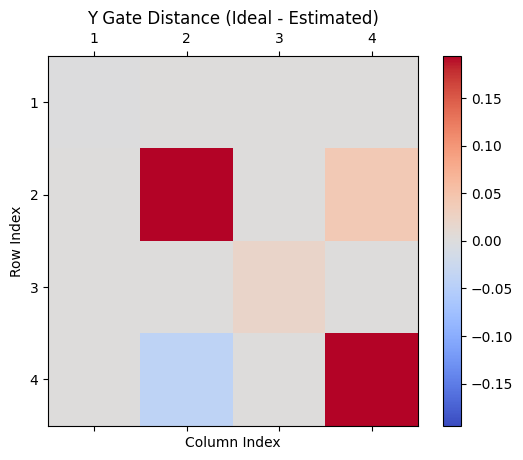

In [94]:
max_abs_Y_ideal = np.max(np.abs(error_Y_ideal_np))
fig, ax = plt.subplots()
cax = ax.matshow(error_Y_ideal_np, cmap='coolwarm', vmin=-max_abs_Y_ideal, vmax=max_abs_Y_ideal)
fig.colorbar(cax)

ax.set_title('Y Gate Distance (Ideal - Estimated)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

ax.set_xticks(np.arange(len(error_Y_ideal_np)))
ax.set_yticks(np.arange(len(error_Y_ideal_np)))
ax.set_xticklabels(np.arange(1, len(error_Y_ideal_np)+1))
ax.set_yticklabels(np.arange(1, len(error_Y_ideal_np)+1))

plt.savefig('Y_gate_distance_ideal_heatmap.eps', format='eps', dpi=300)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

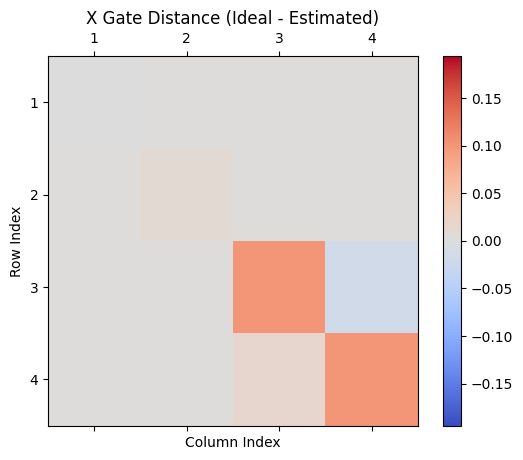

In [95]:
max_abs_Y_ideal = np.max(np.abs(error_Y_ideal_np))
fig, ax = plt.subplots()
cax = ax.matshow(error_X_ideal_np, cmap='coolwarm', vmin=-max_abs_Y_ideal, vmax=max_abs_Y_ideal)
fig.colorbar(cax)

ax.set_title('X Gate Distance (Ideal - Estimated)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

ax.set_xticks(np.arange(len(error_X_ideal_np)))
ax.set_yticks(np.arange(len(error_X_ideal_np)))
ax.set_xticklabels(np.arange(1, len(error_X_ideal_np)+1))
ax.set_yticklabels(np.arange(1, len(error_X_ideal_np)+1))

plt.savefig('X_gate_distance_ideal_heatmap.eps', format='eps', dpi=300)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

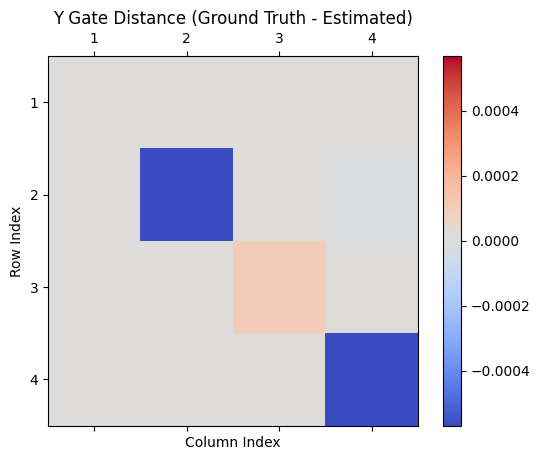

In [96]:
max_abs_Y = np.max(np.abs(error_Y_np))
fig, ax = plt.subplots()
cax = ax.matshow(error_Y_np, cmap='coolwarm', vmin=-max_abs_Y, vmax=max_abs_Y)
fig.colorbar(cax)

ax.set_title('Y Gate Distance (Ground Truth - Estimated)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

ax.set_xticks(np.arange(len(error_Y_np)))
ax.set_yticks(np.arange(len(error_Y_np)))
ax.set_xticklabels(np.arange(1, len(error_Y_np)+1))
ax.set_yticklabels(np.arange(1, len(error_Y_np)+1))

plt.savefig('Y_gate_distance_heatmap.eps', format='eps', dpi=300)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

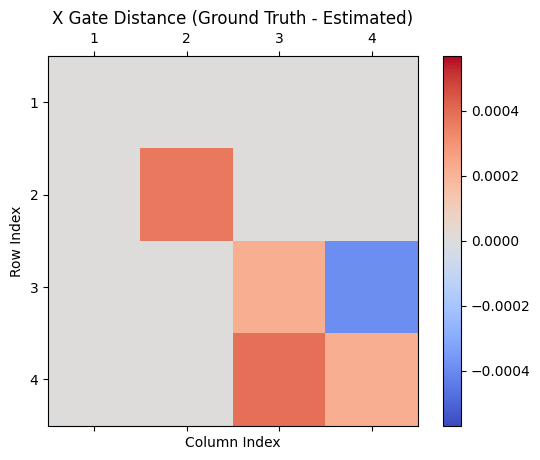

In [97]:
max_abs_Y = np.max(np.abs(error_Y_np))
fig, ax = plt.subplots()
cax = ax.matshow(error_X_np, cmap='coolwarm', vmin=-max_abs_Y, vmax=max_abs_Y)
fig.colorbar(cax)

ax.set_title('X Gate Distance (Ground Truth - Estimated)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

ax.set_xticks(np.arange(len(error_X_np)))
ax.set_yticks(np.arange(len(error_X_np)))
ax.set_xticklabels(np.arange(1, len(error_X_np)+1))
ax.set_yticklabels(np.arange(1, len(error_X_np)+1))

plt.savefig('X_gate_distance_heatmap.eps', format='eps', dpi=300)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

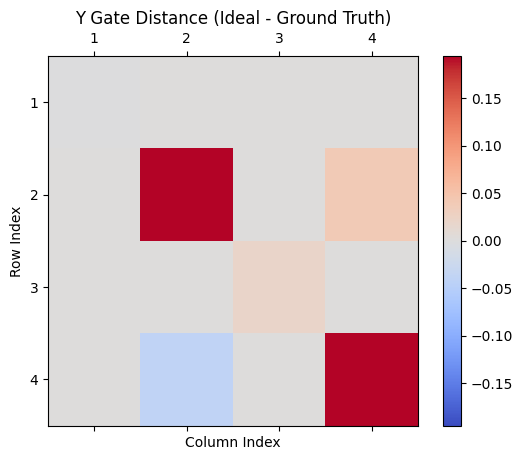

In [98]:
max_abs_Y_ideal_GS = np.max(np.abs(error_Y_ideal_GS_np))
fig, ax = plt.subplots()
cax = ax.matshow(error_Y_ideal_GS_np, cmap='coolwarm', vmin=-max_abs_Y_ideal_GS, vmax=max_abs_Y_ideal_GS)
fig.colorbar(cax)

ax.set_title('Y Gate Distance (Ideal - Ground Truth)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

ax.set_xticks(np.arange(len(error_Y_ideal_GS_np)))
ax.set_yticks(np.arange(len(error_Y_ideal_GS_np)))
ax.set_xticklabels(np.arange(1, len(error_Y_ideal_GS_np)+1))
ax.set_yticklabels(np.arange(1, len(error_Y_ideal_GS_np)+1))

plt.savefig('Y_gate_distance_ideal_GS_heatmap.eps', format='eps', dpi=300)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

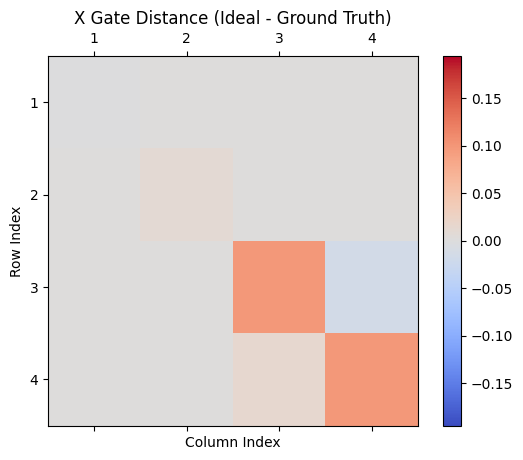

In [99]:
max_abs_Y_ideal_GS = np.max(np.abs(error_Y_ideal_GS_np))
fig, ax = plt.subplots()
cax = ax.matshow(error_X_ideal_GS_np, cmap='coolwarm', vmin=-max_abs_Y_ideal_GS, vmax=max_abs_Y_ideal_GS)
fig.colorbar(cax)

ax.set_title('X Gate Distance (Ideal - Ground Truth)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

ax.set_xticks(np.arange(len(error_X_ideal_GS_np)))
ax.set_yticks(np.arange(len(error_X_ideal_GS_np)))
ax.set_xticklabels(np.arange(1, len(error_X_ideal_GS_np)+1))
ax.set_yticklabels(np.arange(1, len(error_X_ideal_GS_np)+1))

plt.savefig('X_gate_distance_ideal_GS_heatmap.eps', format='eps', dpi=300)
plt.show